Adapted by Rosa Zwart from Jupyter Notebooks found at https://github.com/PPerdomoQ/rare-disease-explainer

# Import Libraries

Package                       Version
----------------------------- ----------
aiosignal                     1.3.1
anyio                         3.6.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
asttokens                     2.2.1
attrs                         22.2.0
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.12.2
bleach                        6.0.0
certifi                       2023.5.7
cffi                          1.15.1
charset-normalizer            3.1.0
click                         8.1.3
colorama                      0.4.6
comm                          0.1.3
contourpy                     1.0.7
cycler                        0.11.0
debugpy                       1.6.6
decorator                     5.1.1
deepsnap                      0.2.1
defusedxml                    0.7.1
distlib                       0.3.6
executing                     1.2.0
fastjsonschema                2.16.3
filelock                      3.12.0
fonttools                     4.39.3
fqdn                          1.5.1
frozenlist                    1.3.3
gensim                        4.3.1
grpcio                        1.54.0
idna                          3.4
importlib-metadata            6.6.0
ipykernel                     6.20.2
ipython                       8.13.2
ipython-genutils              0.2.0
ipywidgets                    8.0.6
isoduration                   20.11.0
jedi                          0.18.2
Jinja2                        3.1.2
joblib                        1.2.0
jsonpointer                   2.3
jsonschema                    4.17.3
jupyter                       1.0.0
jupyter_client                8.2.0
jupyter-console               6.6.3
jupyter_core                  5.3.0
jupyter-events                0.6.3
jupyter_server                2.5.0
jupyter_server_terminals      0.4.4
jupyterlab-pygments           0.2.2
jupyterlab-widgets            3.0.7
kiwisolver                    1.4.4
MarkupSafe                    2.1.2
matplotlib                    3.7.1
matplotlib-inline             0.1.6
mistune                       2.0.5
msgpack                       1.0.5
nbclassic                     1.0.0
nbclient                      0.7.4
nbconvert                     7.4.0
nbformat                      5.8.0
nest-asyncio                  1.5.6
networkx                      3.0
notebook                      6.5.4
notebook_shim                 0.2.3
numpy                         1.24.3
packaging                     23.1
pandas                        1.3.5
pandocfilters                 1.5.0
parso                         0.8.3
pickleshare                   0.7.5
Pillow                        9.5.0
pip                           23.1.2
platformdirs                  3.5.0
prometheus-client             0.16.0
prompt-toolkit                3.0.38
protobuf                      4.23.0
psutil                        5.9.1
pure-eval                     0.2.2
pycparser                     2.21
Pygments                      2.15.1
pyparsing                     3.0.9
pyrsistent                    0.19.3
python-dateutil               2.8.2
python-json-logger            2.0.7
pytz                          2023.3
pywin32                       303
pywinpty                      2.0.10
PyYAML                        6.0
pyzmq                         25.0.2
qtconsole                     5.4.3
QtPy                          2.3.1
ray                           2.3.1
requests                      2.30.0
rfc3339-validator             0.1.4
rfc3986-validator             0.1.1
scikit-learn                  1.2.2
scipy                         1.10.1
Send2Trash                    1.8.2
setuptools                    66.0.0
six                           1.16.0
smart-open                    6.3.0
sniffio                       1.3.0
soupsieve                     2.4.1
stack-data                    0.6.2
tabulate                      0.9.0
terminado                     0.17.1
threadpoolctl                 3.1.0
tinycss2                      1.2.1
torch                         1.11.0+cpu
torch-cluster                 1.6.0
torch-geometric               2.0.4
torch-scatter                 2.0.9
torch-sparse                  0.6.13
torch-spline-conv             1.2.2
torchaudio                    0.11.0+cpu
torchvision                   0.12.0+cpu
tornado                       6.2
tqdm                          4.65.0
traitlets                     5.9.0
typing_extensions             4.5.0
tzdata                        2023.3
uri-template                  1.2.0
urllib3                       2.0.2
virtualenv                    20.23.0
wcwidth                       0.2.6
webcolors                     1.13
webencodings                  0.5.1
websocket-client              1.5.1
wheel                         0.38.4
widgetsnbextension            4.0.7
zipp                          3.15.0

In [16]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle

from gnn.linkpred_model import LinkPredModel, train, test

import torch
from torch.utils.data import DataLoader

from deepsnap.dataset import GraphDataset
from deepsnap.batch import Batch
from deepsnap.graph import Graph

from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

from gensim.models import KeyedVectors

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [17]:
torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', torch_device)

Using device: cpu


Specify which dataset is used, 1 (original knowledge graph) or 2 (restructured knowledge graph)

In [18]:
dataset_nr = 1
assert dataset_nr == 1 or 2

Specify which embedding method is used

In [19]:
embedding_method = 'e2v'
assert embedding_method == 'e2v' or 'm2v'

# Load Data

Load all nodes

In [20]:
nodes = pd.read_csv(f'output/indexed_nodes_{dataset_nr}.csv')
nodes.drop('index_id', axis=1, inplace=True)
nodes['semantic'] = nodes['semantic'].astype('category')
nodes

,id,semantic,label,semantic_id
0,WormBase:WBGene00000389,ORTH,cdc-25.4,5
1,ZP:0018675,DISO,right side lateral plate mesoderm mislocalised...,1
2,ZFIN:ZDB-GENE-040426-1197,ORTH,tbc1d5,5
3,5,DRUG,(S)-nicardipine,2
4,RGD:3443,ORTH,Ptk2,5
...,...,...,...,...
10029,MP:0009763,DISO,increased sensitivity to induced morbidity/mor...,1
10030,MP:0011057,DISO,absent brain ependyma motile cilia,1
10031,MP:0001412,DISO,excessive scratching,1
10032,WBPhenotype:0004023,DISO,frequency of body bend variant,1


The dictionary below can be used as mapping between generated semantic ID and semantic group label.

In [21]:
node_semantic_dict = dict(enumerate(nodes['semantic'].cat.categories))
node_semantic_dict

{0: 'ANAT',
 1: 'DISO',
 2: 'DRUG',
 3: 'GENE',
 4: 'GENO',
 5: 'ORTH',
 6: 'PHYS',
 7: 'VARI'}

Load the node embeddings

In [22]:
def loadEdge2VecEmbedding(): 
    node_feat = KeyedVectors.load(f'output/w2v_{dataset_nr}.dvectors', mmap='r')
    e2v_embedding = pd.DataFrame(columns = ['Node', 'Embedding'])
    for idx, key in enumerate(node_feat.index_to_key):
        e2v_embedding.loc[int(key)] = pd.Series({'Node':int(key), 'Embedding':list(node_feat[key])})
        
    return e2v_embedding.sort_values('Node')

def loadMetapath2VecEmbedding():
    metapath2vec_embedding = pd.read_csv(f'output/metapath2vec_embedding_{dataset_nr}.csv')
    metapath2vec_embedding['Embedding'] = metapath2vec_embedding.values.tolist()
    metapath2vec_embedding = metapath2vec_embedding[['Embedding']]
    metapath2vec_embedding['Node'] = metapath2vec_embedding.index
    return metapath2vec_embedding[['Node', 'Embedding']]

In [23]:
if embedding_method == 'e2v':
    embedding = loadEdge2VecEmbedding()
else:
    embedding = loadMetapath2VecEmbedding()
    
embedding

,Node,Embedding
0,0,"[0.23430845, -0.22153802, 0.29080248, 0.153929..."
1,1,"[0.23548242, -0.19628452, 0.3288001, 0.1936409..."
2,2,"[0.19008121, -0.37460387, 0.43780017, 0.141685..."
3,3,"[0.19433619, -0.21838334, 0.260041, 0.19633888..."
4,4,"[0.4364385, -0.48848882, 0.2483637, 0.44575173..."
...,...,...
10029,10029,"[0.3179047, -0.36064115, 0.32512513, 0.3515173..."
10030,10030,"[0.17949638, -0.20491056, 0.2284929, 0.1872862..."
10031,10031,"[0.32319647, -0.32017368, 0.3412019, 0.3066842..."
10032,10032,"[0.43276545, -0.1972076, 0.46449026, 0.1191806..."


Load the edges

In [24]:
edges = pd.read_csv(f'output/indexed_edges_{dataset_nr}.csv')
edges

,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
0,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0085464,CG34435,5,6825,0
1,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,HGNC:7585,MYL4,3,27,0
2,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,FlyBase:FBgn0002772,Mlc1,5,8901,0
3,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in orthology relationship with,NCBIGene:396472,MYL4,3,9508,0
4,ZFIN:ZDB-GENE-050626-112,myl4,5,5279,in 1 to 1 orthology relationship with,ENSEMBL:ENSECAG00000020967,ENSEMBL:ENSECAG00000020967,5,8807,1
...,...,...,...,...,...,...,...,...,...,...
82908,4810,ibrutinib,2,1618,targets,HGNC:11283,SRC,3,3279,14
82909,522,carvedilol,2,184,targets,HGNC:620,APP,3,547,14
82910,OMIM:300377.0013,"DMD, EX18DEL",1,2822,is allele of,HGNC:2928,DMD,3,6612,16
82911,Coriell:GM05113,NIGMS-GM05113,4,8105,has role in modeling,MONDO:0010679,Duchenne muscular dystrophy,1,6315,15


Index list can be used later for converting back to the label of the relation.

In [25]:
_, relation_labels = pd.factorize(edges['relation'])
relation_labels

Index(['in orthology relationship with',
       'in 1 to 1 orthology relationship with', 'expressed in', 'is part of',
       'has phenotype', 'enables', 'interacts with', 'involved in',
       'colocalizes with', 'is causal germline mutation in',
       'contributes to condition', 'has affected feature',
       'pathogenic for condition', 'contributes to', 'targets',
       'has role in modeling', 'is allele of',
       'likely pathogenic for condition', 'causes condition', 'source',
       'has genotype', 'is causal germline mutation partially giving rise to',
       'is marker for'],
      dtype='object')

# Link Prediction

Creating a graph including the node embeddings as features of each node.

In [26]:
embedded_node_G = nx.Graph() # TODO: DiGraph?

for ind, node in embedding.iterrows(): 
  embedded_node_G.add_node(int(node['Node']), node_feature=torch.Tensor(node['Embedding']))
for ind, edge in edges.iterrows(): 
  embedded_node_G.add_edge(int(edge['index_head']), int(edge['index_tail']))
    
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.2343, -0.2215,  0.2908,  0.1539,  0.2281, -0.6121, -0.1702, -0.1491,
        -0.3883, -0.1492,  0.1752, -0.0812,  0.1012, -0.3064,  0.2251,  0.1858,
        -0.1671,  0.2798, -0.2372,  0.6207,  0.5475,  0.2320,  0.2394, -0.2868,
        -0.1666,  0.2079, -0.4518, -0.1384,  0.1306, -0.3092, -0.2119, -0.2107,
         0.0050, -0.0625,  0.3891,  0.3701, -0.2003,  0.0271,  0.3091,  0.1963,
         0.0304, -0.0834, -0.0321, -0.1079,  0.2217, -0.3191, -0.0803, -0.3379,
        -0.1004,  0.0073, -0.0939, -0.1820,  0.4888,  0.2722,  0.1505,  0.1570,
        -0.1450, -0.5347, -0.3174,  0.0345, -0.2286, -0.1200, -0.1965,  0.0340])})
(0, 5765, {})
Number of edges is 52024
Number of nodes is 10034


## Generate graph datasets for training, validation and testing

Transductive link prediction split (https://zqfang.github.io/2021-08-12-graph-linkpredict/):
- Train/validation/test sets are on the same graph
- The dataset consists of one graph
- The entire graph can be observed in all dataset splits
- The labels of the edges are split

In [27]:
dataset = GraphDataset(
    embedded_node_G,
    task='link_pred',
    edge_train_mode='all'
)

datasets = {}
datasets['train'], datasets['val'], datasets['test'] = dataset.split(
    transductive=True, split_ratio=[0.8, 0.1, 0.1]
)

input_dim = datasets['train'].num_node_features
num_classes = datasets['train'].num_edge_labels

print(f'Input dimension (embedding dimension): {input_dim} \n Number of edge classes (link or no link): {num_classes}')   

c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Input dimension (embedding dimension): 64 
 Number of edge classes (link or no link): 2


Dataloaders allow to feed data into the model by batch.

In [28]:
dataloaders = {split: DataLoader(ds, collate_fn=Batch.collate([]), batch_size=1, shuffle=(split=='train')) for split, ds in datasets.items()}

## Train GNN

### Predefined Arguments

Train GNN with predefined arguments

In [29]:
if dataset_nr == 1:
    args = {
        "device" : torch_device,   # insert torch_device, or 'cpu' 
        "hidden_dim" : 264,
        'output_dim': 64,
        "epochs" : 150, 
        'lr': 0.07, 
        'aggr': 'mean', 
        'layers': 2, 
        'dropout': 0.2
    }
else:
    args = {
        "device" : torch_device,   # insert torch_device, or 'cpu' 
        "hidden_dim" : 256,
        'output_dim': 64,
        "epochs" : 100, 
        'lr': 0.013477408995651594, 
        'aggr': 'mean', 
        'layers': 2, 
        'dropout': 0.2
    }

print(args)

model = LinkPredModel(input_dim, args["hidden_dim"], args['output_dim'], args['layers'], args['aggr'], args['dropout'], args["device"]).to(args["device"])
optimizer = torch.optim.SGD(model.parameters(), lr=args['lr'], momentum=0.9, weight_decay=5e-4)

{'device': device(type='cpu'), 'hidden_dim': 264, 'output_dim': 64, 'epochs': 150, 'lr': 0.07, 'aggr': 'mean', 'layers': 2, 'dropout': 0.2}


In [30]:
best_model, best_x, performance = train(model, dataloaders, optimizer, args)

best_train_roc = test(best_model, dataloaders['train'], args)
best_val_roc = test(best_model, dataloaders['val'], args)
best_test_roc = test(best_model, dataloaders['test'], args)

print('Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(best_train_roc, best_val_roc, best_test_roc))

Start Train Function
Epoch: 001, Train: 0.8888, Val: 0.8800, Test: 0.8857, Loss: 2.48598


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 002, Train: 0.8931, Val: 0.8884, Test: 0.8958, Loss: 2.17458


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 003, Train: 0.8939, Val: 0.8867, Test: 0.8947, Loss: 2.01181


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 004, Train: 0.9043, Val: 0.8871, Test: 0.8974, Loss: 1.90302


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 005, Train: 0.9142, Val: 0.8945, Test: 0.9066, Loss: 1.86416


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 006, Train: 0.9227, Val: 0.9022, Test: 0.9141, Loss: 1.76714


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 007, Train: 0.9215, Val: 0.9019, Test: 0.9121, Loss: 1.60242


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 008, Train: 0.9243, Val: 0.9013, Test: 0.9104, Loss: 1.50929


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 009, Train: 0.9303, Val: 0.9027, Test: 0.9113, Loss: 1.39671


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 010, Train: 0.9390, Val: 0.9075, Test: 0.9164, Loss: 1.29988


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 011, Train: 0.9484, Val: 0.9139, Test: 0.9236, Loss: 1.23560


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 012, Train: 0.9536, Val: 0.9197, Test: 0.9300, Loss: 1.16580


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 013, Train: 0.9568, Val: 0.9249, Test: 0.9357, Loss: 1.08471


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 014, Train: 0.9586, Val: 0.9286, Test: 0.9397, Loss: 0.99463


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 015, Train: 0.9581, Val: 0.9310, Test: 0.9424, Loss: 0.93131


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 016, Train: 0.9575, Val: 0.9322, Test: 0.9437, Loss: 0.86579


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 017, Train: 0.9558, Val: 0.9322, Test: 0.9437, Loss: 0.81027


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 018, Train: 0.9538, Val: 0.9323, Test: 0.9434, Loss: 0.76546


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 019, Train: 0.9539, Val: 0.9330, Test: 0.9435, Loss: 0.71786


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 020, Train: 0.9551, Val: 0.9339, Test: 0.9439, Loss: 0.67412


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 021, Train: 0.9568, Val: 0.9348, Test: 0.9443, Loss: 0.64380


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 022, Train: 0.9578, Val: 0.9358, Test: 0.9447, Loss: 0.61060


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 023, Train: 0.9595, Val: 0.9365, Test: 0.9447, Loss: 0.57665


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 024, Train: 0.9627, Val: 0.9378, Test: 0.9454, Loss: 0.56003


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 025, Train: 0.9638, Val: 0.9395, Test: 0.9465, Loss: 0.54927


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 026, Train: 0.9670, Val: 0.9410, Test: 0.9475, Loss: 0.52399


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 027, Train: 0.9697, Val: 0.9423, Test: 0.9485, Loss: 0.50844


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 028, Train: 0.9724, Val: 0.9441, Test: 0.9500, Loss: 0.49951


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 029, Train: 0.9746, Val: 0.9464, Test: 0.9519, Loss: 0.48544


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 030, Train: 0.9769, Val: 0.9487, Test: 0.9539, Loss: 0.48050


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 031, Train: 0.9796, Val: 0.9506, Test: 0.9555, Loss: 0.47136


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 032, Train: 0.9813, Val: 0.9521, Test: 0.9567, Loss: 0.46587


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 033, Train: 0.9820, Val: 0.9532, Test: 0.9576, Loss: 0.45832


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 034, Train: 0.9833, Val: 0.9540, Test: 0.9582, Loss: 0.45299


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 035, Train: 0.9848, Val: 0.9546, Test: 0.9587, Loss: 0.44810


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 036, Train: 0.9854, Val: 0.9551, Test: 0.9591, Loss: 0.43983


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 037, Train: 0.9859, Val: 0.9554, Test: 0.9594, Loss: 0.43833


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 038, Train: 0.9858, Val: 0.9557, Test: 0.9596, Loss: 0.43762


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 039, Train: 0.9861, Val: 0.9559, Test: 0.9598, Loss: 0.43458


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 040, Train: 0.9869, Val: 0.9561, Test: 0.9600, Loss: 0.43068


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 041, Train: 0.9869, Val: 0.9564, Test: 0.9601, Loss: 0.42663


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 042, Train: 0.9873, Val: 0.9565, Test: 0.9602, Loss: 0.42475


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 043, Train: 0.9874, Val: 0.9566, Test: 0.9603, Loss: 0.42220


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 044, Train: 0.9875, Val: 0.9568, Test: 0.9604, Loss: 0.42122


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 045, Train: 0.9870, Val: 0.9569, Test: 0.9605, Loss: 0.41947


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 046, Train: 0.9877, Val: 0.9570, Test: 0.9606, Loss: 0.41888


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 047, Train: 0.9877, Val: 0.9571, Test: 0.9607, Loss: 0.41854


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 048, Train: 0.9880, Val: 0.9573, Test: 0.9609, Loss: 0.41600


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 049, Train: 0.9880, Val: 0.9575, Test: 0.9611, Loss: 0.41347


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 050, Train: 0.9882, Val: 0.9577, Test: 0.9614, Loss: 0.41248


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 051, Train: 0.9886, Val: 0.9579, Test: 0.9616, Loss: 0.41222


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 052, Train: 0.9886, Val: 0.9580, Test: 0.9618, Loss: 0.41161


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 053, Train: 0.9888, Val: 0.9582, Test: 0.9620, Loss: 0.41097


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 054, Train: 0.9884, Val: 0.9584, Test: 0.9622, Loss: 0.41268


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 055, Train: 0.9885, Val: 0.9587, Test: 0.9624, Loss: 0.40857


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 056, Train: 0.9890, Val: 0.9590, Test: 0.9627, Loss: 0.40713


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 057, Train: 0.9889, Val: 0.9594, Test: 0.9631, Loss: 0.40773


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 058, Train: 0.9890, Val: 0.9598, Test: 0.9634, Loss: 0.40749


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 059, Train: 0.9889, Val: 0.9602, Test: 0.9638, Loss: 0.40648


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 060, Train: 0.9890, Val: 0.9608, Test: 0.9643, Loss: 0.40579


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 061, Train: 0.9896, Val: 0.9613, Test: 0.9648, Loss: 0.40498


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 062, Train: 0.9893, Val: 0.9619, Test: 0.9652, Loss: 0.40484


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 063, Train: 0.9899, Val: 0.9624, Test: 0.9657, Loss: 0.40604


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 064, Train: 0.9896, Val: 0.9630, Test: 0.9662, Loss: 0.40485


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 065, Train: 0.9898, Val: 0.9636, Test: 0.9666, Loss: 0.40240


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 066, Train: 0.9901, Val: 0.9641, Test: 0.9671, Loss: 0.40308


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 067, Train: 0.9902, Val: 0.9646, Test: 0.9675, Loss: 0.40240


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 068, Train: 0.9907, Val: 0.9651, Test: 0.9678, Loss: 0.40179


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 069, Train: 0.9906, Val: 0.9655, Test: 0.9682, Loss: 0.40197


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 070, Train: 0.9907, Val: 0.9659, Test: 0.9685, Loss: 0.39929


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 071, Train: 0.9907, Val: 0.9662, Test: 0.9688, Loss: 0.39960


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 072, Train: 0.9906, Val: 0.9665, Test: 0.9690, Loss: 0.39945


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 073, Train: 0.9913, Val: 0.9669, Test: 0.9693, Loss: 0.40087


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 074, Train: 0.9912, Val: 0.9673, Test: 0.9696, Loss: 0.39998


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 075, Train: 0.9912, Val: 0.9676, Test: 0.9699, Loss: 0.39938


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 076, Train: 0.9912, Val: 0.9679, Test: 0.9701, Loss: 0.39967


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 077, Train: 0.9917, Val: 0.9682, Test: 0.9704, Loss: 0.39745


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 078, Train: 0.9916, Val: 0.9685, Test: 0.9706, Loss: 0.39796


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 079, Train: 0.9916, Val: 0.9689, Test: 0.9709, Loss: 0.39857


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 080, Train: 0.9916, Val: 0.9691, Test: 0.9711, Loss: 0.39932


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 081, Train: 0.9917, Val: 0.9694, Test: 0.9713, Loss: 0.39841


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 082, Train: 0.9919, Val: 0.9696, Test: 0.9715, Loss: 0.39856


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 083, Train: 0.9920, Val: 0.9698, Test: 0.9717, Loss: 0.39786


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 084, Train: 0.9921, Val: 0.9700, Test: 0.9718, Loss: 0.39728


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 085, Train: 0.9917, Val: 0.9702, Test: 0.9719, Loss: 0.39652


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 086, Train: 0.9925, Val: 0.9703, Test: 0.9720, Loss: 0.39719


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 087, Train: 0.9924, Val: 0.9704, Test: 0.9721, Loss: 0.39744


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 088, Train: 0.9925, Val: 0.9705, Test: 0.9722, Loss: 0.39646


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 089, Train: 0.9924, Val: 0.9707, Test: 0.9723, Loss: 0.39597


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 090, Train: 0.9929, Val: 0.9708, Test: 0.9724, Loss: 0.39723


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 091, Train: 0.9926, Val: 0.9708, Test: 0.9724, Loss: 0.39637


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 092, Train: 0.9928, Val: 0.9709, Test: 0.9725, Loss: 0.39668


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 093, Train: 0.9930, Val: 0.9711, Test: 0.9727, Loss: 0.39501


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 094, Train: 0.9929, Val: 0.9712, Test: 0.9728, Loss: 0.39431


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 095, Train: 0.9929, Val: 0.9713, Test: 0.9728, Loss: 0.39477


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 096, Train: 0.9930, Val: 0.9715, Test: 0.9730, Loss: 0.39453


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 097, Train: 0.9931, Val: 0.9716, Test: 0.9731, Loss: 0.39391


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 098, Train: 0.9931, Val: 0.9718, Test: 0.9732, Loss: 0.39335


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 099, Train: 0.9934, Val: 0.9719, Test: 0.9734, Loss: 0.39459


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 100, Train: 0.9933, Val: 0.9721, Test: 0.9735, Loss: 0.39571


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 101, Train: 0.9933, Val: 0.9723, Test: 0.9737, Loss: 0.39491


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 102, Train: 0.9934, Val: 0.9725, Test: 0.9739, Loss: 0.39286


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 103, Train: 0.9935, Val: 0.9726, Test: 0.9740, Loss: 0.39465


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 104, Train: 0.9935, Val: 0.9728, Test: 0.9742, Loss: 0.39298


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 105, Train: 0.9934, Val: 0.9729, Test: 0.9743, Loss: 0.39454


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 106, Train: 0.9935, Val: 0.9731, Test: 0.9744, Loss: 0.39228


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 107, Train: 0.9936, Val: 0.9732, Test: 0.9745, Loss: 0.39365


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 108, Train: 0.9934, Val: 0.9733, Test: 0.9746, Loss: 0.39217


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 109, Train: 0.9936, Val: 0.9734, Test: 0.9747, Loss: 0.39425


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 110, Train: 0.9940, Val: 0.9735, Test: 0.9747, Loss: 0.39343


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 111, Train: 0.9938, Val: 0.9735, Test: 0.9748, Loss: 0.39333


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 112, Train: 0.9940, Val: 0.9736, Test: 0.9749, Loss: 0.39196


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 113, Train: 0.9940, Val: 0.9737, Test: 0.9750, Loss: 0.39196


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 114, Train: 0.9939, Val: 0.9739, Test: 0.9751, Loss: 0.39208


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 115, Train: 0.9938, Val: 0.9740, Test: 0.9752, Loss: 0.39080


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 116, Train: 0.9940, Val: 0.9741, Test: 0.9753, Loss: 0.39321


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 117, Train: 0.9940, Val: 0.9741, Test: 0.9753, Loss: 0.39157


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 118, Train: 0.9941, Val: 0.9741, Test: 0.9753, Loss: 0.39191


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 119, Train: 0.9942, Val: 0.9742, Test: 0.9754, Loss: 0.39261


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 120, Train: 0.9942, Val: 0.9742, Test: 0.9754, Loss: 0.39243


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 121, Train: 0.9942, Val: 0.9743, Test: 0.9754, Loss: 0.39117


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 122, Train: 0.9941, Val: 0.9743, Test: 0.9754, Loss: 0.39028


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 123, Train: 0.9942, Val: 0.9743, Test: 0.9754, Loss: 0.39119


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 124, Train: 0.9942, Val: 0.9743, Test: 0.9754, Loss: 0.39120


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 125, Train: 0.9943, Val: 0.9743, Test: 0.9755, Loss: 0.39215


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 126, Train: 0.9940, Val: 0.9743, Test: 0.9754, Loss: 0.39138


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 127, Train: 0.9945, Val: 0.9743, Test: 0.9754, Loss: 0.39040


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 128, Train: 0.9945, Val: 0.9742, Test: 0.9754, Loss: 0.39090


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 129, Train: 0.9945, Val: 0.9742, Test: 0.9754, Loss: 0.38996


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 130, Train: 0.9945, Val: 0.9742, Test: 0.9754, Loss: 0.39131


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 131, Train: 0.9947, Val: 0.9741, Test: 0.9753, Loss: 0.39008


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 132, Train: 0.9944, Val: 0.9741, Test: 0.9753, Loss: 0.39011


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 133, Train: 0.9947, Val: 0.9741, Test: 0.9753, Loss: 0.39064


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 134, Train: 0.9945, Val: 0.9741, Test: 0.9753, Loss: 0.39082


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 135, Train: 0.9945, Val: 0.9741, Test: 0.9753, Loss: 0.39010


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 136, Train: 0.9946, Val: 0.9742, Test: 0.9753, Loss: 0.38936


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 137, Train: 0.9948, Val: 0.9742, Test: 0.9754, Loss: 0.38967


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 138, Train: 0.9945, Val: 0.9743, Test: 0.9754, Loss: 0.38979


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 139, Train: 0.9950, Val: 0.9744, Test: 0.9755, Loss: 0.39154


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 140, Train: 0.9949, Val: 0.9744, Test: 0.9755, Loss: 0.38848


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 141, Train: 0.9949, Val: 0.9745, Test: 0.9756, Loss: 0.39003


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 142, Train: 0.9947, Val: 0.9746, Test: 0.9756, Loss: 0.39014


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 143, Train: 0.9951, Val: 0.9747, Test: 0.9758, Loss: 0.38971


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 144, Train: 0.9949, Val: 0.9748, Test: 0.9759, Loss: 0.39017


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 145, Train: 0.9949, Val: 0.9750, Test: 0.9761, Loss: 0.38888


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 146, Train: 0.9948, Val: 0.9752, Test: 0.9762, Loss: 0.38869


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 147, Train: 0.9950, Val: 0.9753, Test: 0.9763, Loss: 0.38824


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 148, Train: 0.9947, Val: 0.9754, Test: 0.9764, Loss: 0.38818


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Epoch: 149, Train: 0.9950, Val: 0.9754, Test: 0.9764, Loss: 0.38851


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


Train: 0.9950, Val: 0.9754, Test: 0.9764


Save the model and parameters

In [31]:
torch.save(best_model.state_dict(), f'output/best_model_{dataset_nr}.pth')
with open(f'output/best_model_{dataset_nr}_args.pkl', 'wb') as f:
    pickle.dump(args, f)

### Visualize Trained GNN Model Accuracy

Plot AUC and loss throughout epochs

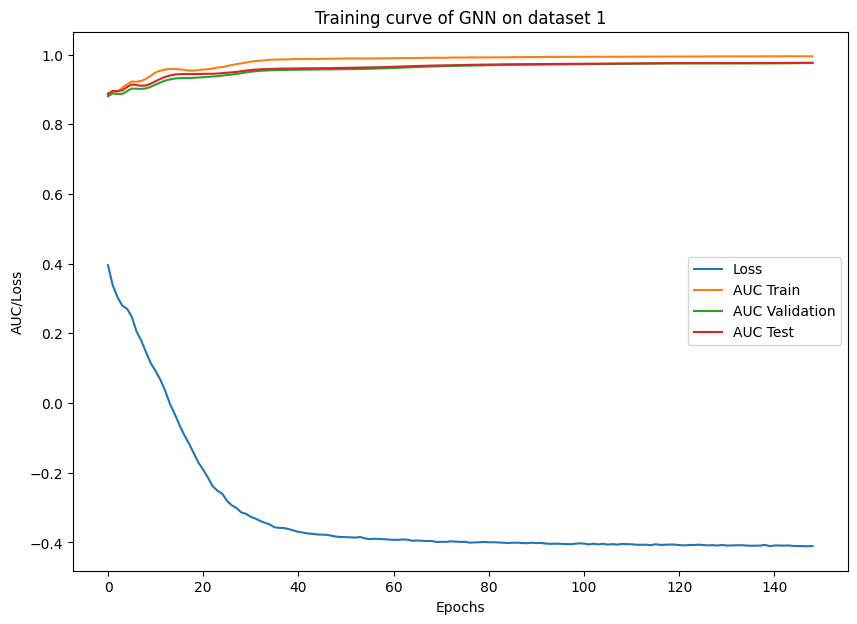

In [32]:
plt.figure(figsize= (10,7))
plt.plot(np.log10(performance[0]), label = 'Loss')
plt.plot(performance[1], label = 'AUC Train')
plt.plot(performance[2], label = 'AUC Validation')
plt.plot(performance[3], label = 'AUC Test')
plt.legend()
plt.ylabel('AUC/Loss')
plt.xlabel('Epochs')
plt.title(f'Training curve of GNN on dataset {dataset_nr}')
plt.show()

Plot ROC curve using test set
- High TPR and lower FPR indicates that the proportion of correctly classified samples (true positives) is greater than the proportion of incorrectly classified samples (false positives)

0.903343349187943


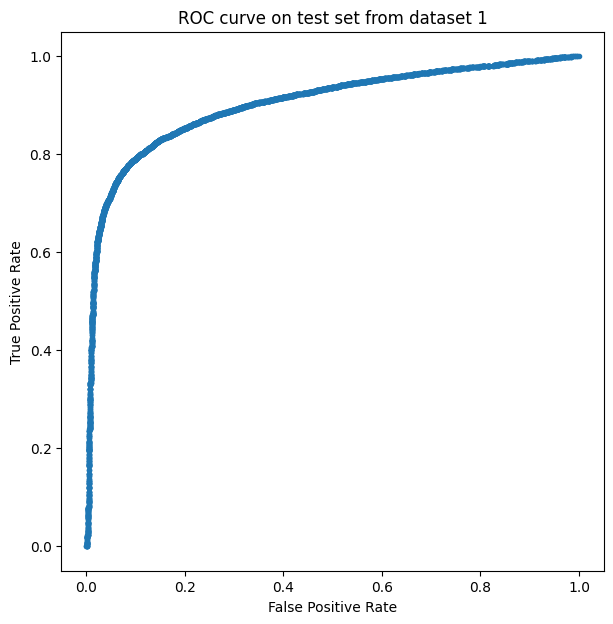

In [82]:
for batch in dataloaders['test']:
    feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
    batch.to(args["device"])
    pred, x = best_model(feat, edge_index, edge_label_index, training = False)
    pred = torch.sigmoid(pred)
    score = roc_auc_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    print(score)
    
fpr, tpr, thresholds = roc_curve(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
plt.figure(figsize = (7, 7))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')   # 1 - specificity
plt.ylabel('True Positive Rate')    # sensitivity
plt.title(f'ROC curve on test set from dataset {dataset_nr}')
plt.show()

Calculate F1-score using test set

Elements of the F1-score:
- Precision represents the proportion of correctly classifying samples as positive (high precision: classifying a sample as positive has a high probability to be correct)
- Recall represents the proportion of finding all positives (high recall: all positive samples have been classified as being positive)

Maximizing both elements in order to yield a model that identifies all positive samples and only identifies these samples as positives.

For the F1-score, the average of precision and recall is calculated, using the harmonic mean method (equal importance):
- High F1-score indicates that precision and recall are both high
- Medium F1-score indicates that one of the elements is high and the other low
- Low F1-score indicates that precision and recall are both low

In [15]:
def test_f1(model, dataloader, args, threshold):
    model.eval()
    score = 0
    num_batches = 0
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score += f1_score(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
        num_batches += 1
    score /= num_batches 
    return batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy(), score

true_label, pred_label, best_test_f1 = test_f1(best_model, dataloaders['test'], args, 0.75)
print(f'F1-Score in the test set of dataset {dataset_nr}:', best_test_f1)
print(classification_report(true_label, pred_label))

F1-Score in the test set of dataset 1: 0.9447065940713854
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      8291
           1       0.95      0.94      0.94      8291

    accuracy                           0.94     16582
   macro avg       0.94      0.94      0.94     16582
weighted avg       0.94      0.94      0.94     16582



In [16]:
def test_cm(model, dataloader, args, threshold):
    model.eval()
    for batch in dataloader:
        feat, edge_index, edge_label_index = batch.node_feature, batch.edge_index, batch.edge_label_index
        batch.to(args["device"])
        pred, x = model(feat, edge_index, edge_label_index, training = False)
        pred = torch.sigmoid(pred) > threshold
        score = confusion_matrix(batch.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    return score

table = test_cm(best_model, dataloaders['train'], args, 0.8)
print(table)

[[63963  2356]
 [ 2636 63683]]


c:\Users\rosa-\anaconda3\envs\xaifo\lib\site-packages\deepsnap\graph.py:2126: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  row = perm // num_nodes


# Hyperparameter Optimization of Node Embedding and GNN Training

The routine including node embedding and GNN training that needs to be optimized is contained in `hyperparam_opt.py`.

# GNN Predictions

Load the Edge2Vec embedding

In [17]:
embedding

,Node,Embedding
0,0,"[0.09083791, 0.64974296, 0.7782852, 0.25919193..."
1,1,"[0.15716696, 0.0034764674, 0.1479481, 0.108134..."
2,2,"[0.42515945, -0.617652, 0.805783, 0.35255384, ..."
3,3,"[0.2717513, -0.3064278, 0.1124591, 0.38972694,..."
4,4,"[0.57811725, -0.17772698, -0.112528116, 0.5507..."
...,...,...
10029,10029,"[0.34240082, -0.38084978, 0.16754319, 0.720097..."
10030,10030,"[0.25831556, -0.22565734, 0.29581633, 0.272049..."
10031,10031,"[0.44271225, -0.29667243, 0.18890032, 0.576830..."
10032,10032,"[0.31620622, -0.07276407, 0.74929845, 0.075423..."


Initialize a graph with nodes and their embedding features.

In [19]:
for node in embedded_node_G.nodes(data=True):
    print(node)
    break
for edge in embedded_node_G.edges(data=True):
    print(edge)
    break

print("Number of edges is {}".format(embedded_node_G.number_of_edges()))
print("Number of nodes is {}".format(embedded_node_G.number_of_nodes()))

(0, {'node_feature': tensor([ 0.0908,  0.6497,  0.7783,  0.2592, -0.3890, -0.3893, -0.3067,  0.1439,
        -0.6868,  0.2832,  0.0500, -0.2312, -0.4122,  0.1875,  0.2706,  0.8355,
         0.0015, -0.3863, -0.5794,  0.8096,  0.2541,  0.9824, -0.3287,  0.4029,
         0.0530,  0.7307, -0.5185, -0.0015,  0.6087,  0.1035, -0.0539,  0.6877,
        -0.1114, -0.6363,  0.5413,  0.5248,  0.4756,  0.5064,  0.1237,  0.0172,
         0.3695,  0.7431,  0.1255, -0.0350,  0.8183, -0.5830,  0.0410, -0.2480,
         0.7220, -0.2687,  0.9163,  0.0490,  0.3611, -0.2805,  0.2794,  0.0380,
        -0.2670, -0.8113,  0.0804,  0.5752,  0.4569, -0.4111, -0.1957, -0.3623])})
(0, 6308, {})
Number of edges is 82899
Number of nodes is 10034


In [20]:
DeepG = Graph(embedded_node_G)
print(DeepG.edge_index.shape)

torch.Size([2, 82899])


Load arguments and parameters of trained GNN model.

In [21]:
with open(f'output/best_model_{dataset_nr}_args.pkl', 'rb') as f:
    loaded_args = pickle.load(f)
    
best_model = LinkPredModel(len(embedding['Embedding'][0]), loaded_args['hidden_dim'], loaded_args['output_dim'], loaded_args['layers'], loaded_args['aggr'], loaded_args['dropout'], loaded_args['device']).to(loaded_args['device'])
best_model.load_state_dict(torch.load(f'output/best_model_{dataset_nr}.pth'))

<All keys matched successfully>

Get output of best model given the graph

In [22]:
_, best_x = best_model(DeepG.node_feature, DeepG.edge_index, DeepG.edge_label_index, training = False)
print(best_x.shape)

torch.Size([10034, 128])


In [24]:
nodes

,index_id,id,semantic,label,semantic_id
0,0,WormBase:WBGene00000389,ORTH,cdc-25.4,5
1,1,ZP:0018675,DISO,right side lateral plate mesoderm mislocalised...,1
2,2,ZFIN:ZDB-GENE-040426-1197,ORTH,tbc1d5,5
3,3,5,DRUG,(S)-nicardipine,2
4,4,RGD:3443,ORTH,Ptk2,5
...,...,...,...,...,...
10029,10029,MP:0009763,DISO,increased sensitivity to induced morbidity/mor...,1
10030,10030,MP:0011057,DISO,absent brain ependyma motile cilia,1
10031,10031,MP:0001412,DISO,excessive scratching,1
10032,10032,WBPhenotype:0004023,DISO,frequency of body bend variant,1


Define the score function

In [25]:
def score(x, id1, id2): 
    n1 = x[id1]
    n2 = x[id2]
    score = torch.Tensor([torch.sum(n1 * n2, dim=-1)])
    p = torch.sigmoid(score).cpu().detach().numpy()
    return p

def candidates(nodes, id, x): 
  ind = nodes[nodes['id'] == id].index.values.astype(int)[0]
  predictions = nodes.copy()
  scores = []
  for i in range(len(x)):  
    s = score(x, i, ind)
    scores.append(s)
  predictions['Score'] = scores
  return predictions

Calculate the predictions of an edge existing or not between given node ID and each node in the graph contained by semantic group DRUG. Show the top 20 highest probability that an edge exists between a pair of nodes.

In [28]:
if dataset_nr == 1:
    drug_semantic = 'DRUG'
else:
    drug_semantic = 'drug'

predictions = candidates(nodes, 'HP:0001265', best_x)
predictions[predictions['semantic'] == drug_semantic].sort_values(by = ['Score'], ascending = False).head(20)

,id,semantic,label,semantic_id,Score
1772,5252,DRUG,neratinib,2,[0.8860187]
1408,4187,DRUG,crizotinib,2,[0.8077064]
1796,5345,DRUG,entrectinib,2,[0.79940796]
204,606,DRUG,chloropyramine,2,[0.79252887]
1790,5330,DRUG,selinexor,2,[0.7858968]
30,73,DRUG,acepromazine,2,[0.7406401]
1456,4318,DRUG,afatinib,2,[0.72511786]
208,624,DRUG,chlortetracycline,2,[0.7221485]
726,2183,DRUG,pipecuronium,2,[0.7137144]
1444,4301,DRUG,Flutemetamol (18F),2,[0.711623]


Use the node semantics dictionary

In [29]:
node_semantics = nodes[['semantic', 'semantic_id']].drop_duplicates().set_index('semantic_id').to_dict()
node_semantics_dict = node_semantics['semantic']
node_semantics_dict

{5: 'ORTH',
 1: 'DISO',
 2: 'DRUG',
 4: 'GENO',
 7: 'VARI',
 3: 'GENE',
 0: 'ANAT',
 6: 'PHYS'}

Get all phenotypes and diseases relevant to the disease.

In [31]:
if dataset_nr == 1:
    pheno_rel = 'has phenotype'
else:
    pheno_rel = 'associated with phenotype'

disease_ID = 'MONDO:0010679'
relation_index = list(relation_labels).index(pheno_rel)

symptoms = edges[(edges['head'] == 'MONDO:0010679') & (edges['type'] == relation_index)]

print(f'A total of {symptoms.shape[0]} symptoms found that are associated with {disease_ID}')
symptoms.head(symptoms.shape[0])

A total of 27 symptoms found that are associated with MONDO:0010679


,head,label_head,class_head,index_head,relation,tail,label_tail,class_tail,index_tail,type
37667,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0011675,Arrhythmia,1,9512,4
37668,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0002515,Waddling gait,1,552,4
37670,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003236,Elevated serum creatine kinase,1,1990,4
37671,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0002093,Respiratory insufficiency,1,4440,4
37672,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003707,Calf muscle pseudohypertrophy,1,357,4
37673,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0001256,"Intellectual disability, mild",1,4247,4
37674,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003701,Proximal muscle weakness,1,5299,4
37675,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003202,Skeletal muscle atrophy,1,4453,4
37676,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003560,Muscular dystrophy,1,2788,4
37677,MONDO:0010679,Duchenne muscular dystrophy,1,6315,has phenotype,HP:0003391,Gowers sign,1,3055,4


Check alignment between dataframes containing the associations and the nodes

In [32]:
nodes.loc[[6315]]

,id,semantic,label,semantic_id
6315,MONDO:0010679,DISO,Duchenne muscular dystrophy,1


Get list of drugs that appear at least once in the top 3 of suggested drugs for an associated phenotype

In [33]:
def add_drug_candidate(candidates, drug_name):
    if drug_name in candidates:
        candidates[drug_name] += 1
    else:
        candidates[drug_name] = 1
        
    return candidates

drug_candidates = {}
symptom_drugs = {}

for ind, symptom in symptoms.iterrows(): 
    symptom_id = symptom['tail']
    symptom_drugs[symptom_id] = []
    
    predictions = candidates(nodes, symptom_id, best_x)
    ordered_predictions = predictions[predictions['semantic'] == drug_semantic].sort_values(by = ['Score'], ascending = False).head(3)
    
    for ind, drug in ordered_predictions.iterrows():
        symptom_drugs[symptom_id].append(drug['id'])
        drug_candidates = add_drug_candidate(drug_candidates, drug['label'])

Get list of drug candidate ids per relevant symptom id.

In [34]:
symptom_drugs_df_dict = {
    'Symptom': [],
    'Candidates': [] 
}
for key, val in symptom_drugs.items():
    symptom_drugs_df_dict['Symptom'].append(key)
    symptom_drugs_df_dict['Candidates'].append(val)
    
symptom_drugs_df = pd.DataFrame.from_dict(symptom_drugs_df_dict)
symptom_drugs_df.to_csv(f'output/symptom_drugs_{dataset_nr}.csv', index=False)

symptom_drugs_df

,Symptom,Candidates
0,HP:0011675,"[5252, 1934, 606]"
1,HP:0002515,"[5252, 4187, 606]"
2,HP:0003236,"[5252, 1971, 908]"
3,HP:0002093,"[1971, 5252, 73]"
4,HP:0003707,"[5252, 5330, 4187]"
5,HP:0001256,"[5252, 5345, 4187]"
6,HP:0003701,"[5252, 4187, 5345]"
7,HP:0003202,"[5252, 606, 5345]"
8,HP:0003560,"[4902, 4301, 5182]"
9,HP:0003391,"[5252, 606, 5345]"


Save dataframe as csv file with all drugs and their total of appearances as a candidate for one or more relevant symptoms.

In [35]:
drug_candidate_df_dict = {
    'Drug': [],
    'Appearances': [],
    'Percentage': []
}
for key, val in drug_candidates.items():
    drug_candidate_df_dict['Drug'].append(key)
    drug_candidate_df_dict['Appearances'].append(val)
    drug_candidate_df_dict['Percentage'].append(val/symptoms.shape[0]*100)
    
drug_candidates_df = pd.DataFrame.from_dict(drug_candidate_df_dict)
drug_candidates_df['Percentage'] = drug_candidates_df['Percentage'].transform(lambda x: '{:,.2f}%'.format(x))
drug_candidates_df = drug_candidates_df.sort_values(by = ['Appearances'], ascending = False)

drug_candidates_df.to_csv(f'output/drug_candidates_{dataset_nr}.csv', index=False)

drug_candidates_df

,Drug,Appearances,Percentage
0,neratinib,25,92.59%
2,chloropyramine,12,44.44%
3,crizotinib,12,44.44%
8,entrectinib,12,44.44%
7,selinexor,4,14.81%
4,nortriptyline,3,11.11%
6,acepromazine,2,7.41%
10,Flutemetamol (18F),2,7.41%
11,eteplirsen,2,7.41%
1,nilvadipine,1,3.70%


## Component Analysis

In [36]:
X_data = best_x.detach().cpu().numpy()
z = StandardScaler().fit_transform(X_data)

### PCA

In [37]:
pca = PCA(n_components=32)
princ_comp = pca.fit_transform(z)
princ_df = pd.DataFrame(data=princ_comp[:, [0,1]], columns=['principal component 1', 'principal component 2'])
princ_df

,principal component 1,principal component 2
0,-0.601489,0.185530
1,2.306813,-1.524685
2,-1.319286,0.984035
3,-0.258733,-0.967167
4,-1.996289,0.412887
...,...,...
10029,-1.526361,1.294888
10030,0.662773,-0.124591
10031,-0.048687,0.096513
10032,0.050731,-1.147563


Based on plot below, choose the number of components for PCA analysis yielding an amount of variance close to 1.0.

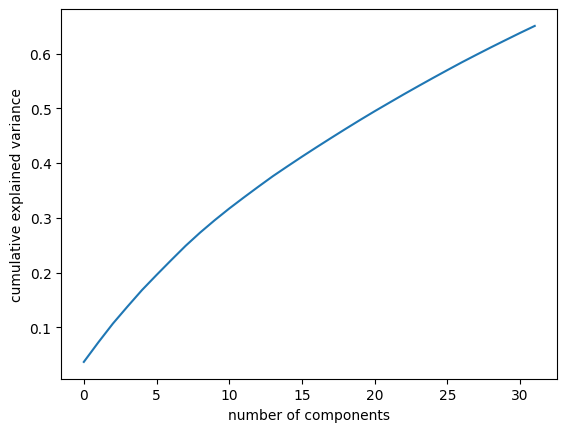

In [38]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [39]:
pca_df = pd.concat([princ_df, nodes[['semantic']]], axis=1)
pca_df

,principal component 1,principal component 2,semantic
0,-0.601489,0.185530,ORTH
1,2.306813,-1.524685,DISO
2,-1.319286,0.984035,ORTH
3,-0.258733,-0.967167,DRUG
4,-1.996289,0.412887,ORTH
...,...,...,...
10029,-1.526361,1.294888,DISO
10030,0.662773,-0.124591,DISO
10031,-0.048687,0.096513,DISO
10032,0.050731,-1.147563,DISO


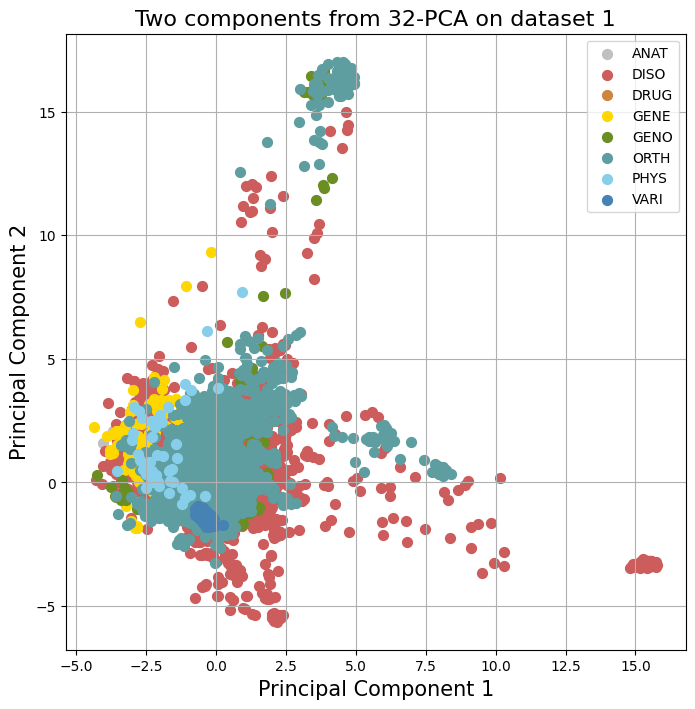

In [46]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two components from 32-PCA on dataset {dataset_nr}', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = pca_df['semantic'] == target
    ax.scatter(pca_df.loc[indicesToKeep, 'principal component 1'], pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()

### t-SNE

In [47]:
X_tsne = TSNE(learning_rate=100, perplexity=40).fit_transform(X_data)

In [48]:
comp_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])
comp_tsne

,t-SNE 1,t-SNE 2
0,16.644581,17.272015
1,54.724277,-31.808844
2,1.172849,41.032772
3,-23.359966,52.627708
4,-7.242720,-19.102787
...,...,...
10029,-19.364267,-14.032401
10030,-21.724602,-49.554306
10031,-6.060464,-33.491642
10032,48.999554,10.894489


In [49]:
tsne_df = pd.concat([comp_tsne, nodes[['semantic']]], axis=1)
tsne_df

,t-SNE 1,t-SNE 2,semantic
0,16.644581,17.272015,ORTH
1,54.724277,-31.808844,DISO
2,1.172849,41.032772,ORTH
3,-23.359966,52.627708,DRUG
4,-7.242720,-19.102787,ORTH
...,...,...,...
10029,-19.364267,-14.032401,DISO
10030,-21.724602,-49.554306,DISO
10031,-6.060464,-33.491642,DISO
10032,48.999554,10.894489,DISO


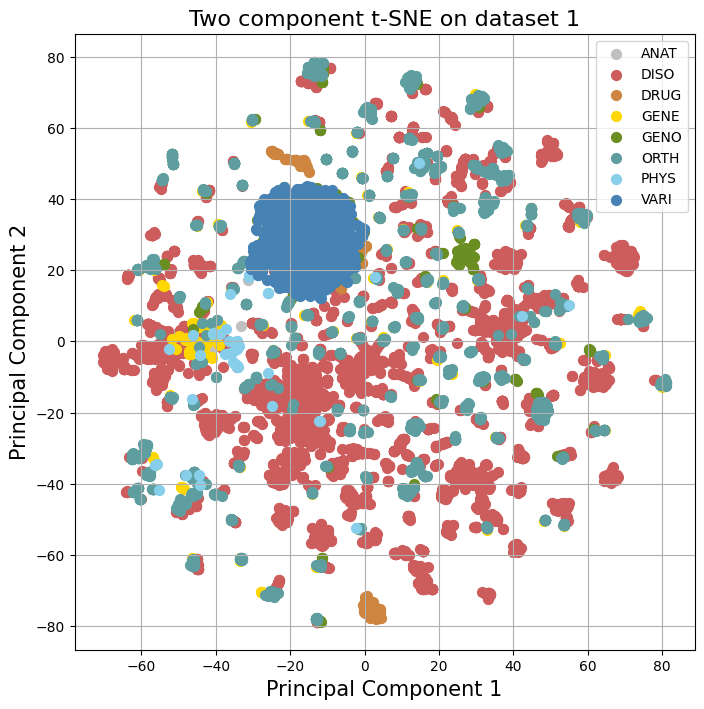

In [50]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title(f'Two component t-SNE on dataset {dataset_nr}', fontsize = 16)

unique_node_semantics = list(node_semantic_dict.values())
colors = ['silver', 'indianred', 'peru', 'gold', 'olivedrab', 'cadetblue', 'skyblue', 'steelblue', 'royalblue', 'mediumpurple', 'palevioletred', 'lightpink']

for target, color in zip(unique_node_semantics, colors):
    indicesToKeep = tsne_df['semantic'] == target
    ax.scatter(tsne_df.loc[indicesToKeep, 't-SNE 1'], tsne_df.loc[indicesToKeep, 't-SNE 2'], c = color, s = 50)
    
ax.legend(unique_node_semantics)
ax.grid()

plt.show()